# CCFDetector: Using ML against Credit Card Frauds

L'obiettivo di questo progetto, realizzato per l'esame di Fondamenti di Intelligenza Artificiale presso l'Univeristà degli Studi di Salerno, è quello di realizzare un sistema di Machine Learning per l'individuazione di transazioni fraudolente relative ai pagamenti elettronici, cioè tutte quelle transazioni effettuate da carte di credito senza l'autorizzazione dei possessori .
## Setup del progetto e Data Understanding
---
### Inizio ad importare le librerie necessarie

In [35]:
# import the necessary packages 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib import gridspec
import plotly.express as px

### Caricamento del dataset
Il dataset contiene più di 20 milioni di righe, dunque, per motivi legati alla capacità dell'hardware, ne andrò a selezionare 300.000.

In [36]:
df = pd.read_csv('credit_card_transactions-ibm_v2.csv').sample(n=300000, random_state=42)
df.head(10)

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
18199893,1470,0,2019,7,10,00:11,$59.18,Chip Transaction,-6853385250336487907,Harwood,MD,20776.0,5813,NaN,No
9731325,822,1,2019,1,14,22:12,$280.91,Online Transaction,4241336128694185533,ONLINE,NaN,NaN,4814,NaN,No
536687,41,3,2010,3,15,07:07,$-144.00,Swipe Transaction,190253443608377572,Hemet,CA,92543.0,3359,NaN,No
13223840,1084,0,2015,9,20,14:58,$6.76,Chip Transaction,-7837310524365334241,Littleton,CO,80122.0,5300,NaN,No
17070521,1384,0,2014,10,12,11:44,$9.17,Swipe Transaction,-5023497618971072366,Gardner,KS,66030.0,5812,NaN,No
792843,55,3,2006,6,10,09:15,$1.36,Swipe Transaction,-6571010470072147219,Rego Park,NY,11374.0,5499,NaN,No
8966297,776,0,2007,2,25,22:31,$97.81,Swipe Transaction,-6974082828836151610,Milwaukee,WI,53224.0,4900,NaN,No
895801,66,0,2007,8,21,13:02,$23.25,Swipe Transaction,3675785629314646441,Gonzales,TX,78629.0,7349,NaN,No
22902727,1880,2,2010,12,31,01:06,$486.70,Swipe Transaction,-3398248499422470718,Atlantic City,NJ,8401.0,7995,NaN,No
5845532,490,5,2015,11,28,13:45,$92.67,Chip Transaction,4722913068560264812,Pompano Beach,FL,33063.0,5411,NaN,No


In [37]:
# Controllo che siano state importate anche transazioni fraudolente
df[df['Is Fraud?'] == 'Yes'].shape

(388, 15)

### Descrizione del dataset


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300000 entries, 18199893 to 18106096
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   User            300000 non-null  int64  
 1   Card            300000 non-null  int64  
 2   Year            300000 non-null  int64  
 3   Month           300000 non-null  int64  
 4   Day             300000 non-null  int64  
 5   Time            300000 non-null  object 
 6   Amount          300000 non-null  object 
 7   Use Chip        300000 non-null  object 
 8   Merchant Name   300000 non-null  int64  
 9   Merchant City   300000 non-null  object 
 10  Merchant State  266377 non-null  object 
 11  Zip             264443 non-null  float64
 12  MCC             300000 non-null  int64  
 13  Errors?         4778 non-null    object 
 14  Is Fraud?       300000 non-null  object 
dtypes: float64(1), int64(7), object(7)
memory usage: 36.6+ MB


Come si può osservare, le caratteristiche *Merchant State*, *Zip* ed *Errors?* contengono dei valori nulli. Vado a generare un istogramma per la visualizzazione della percentuale di valori nulli per ciascun attributo. 

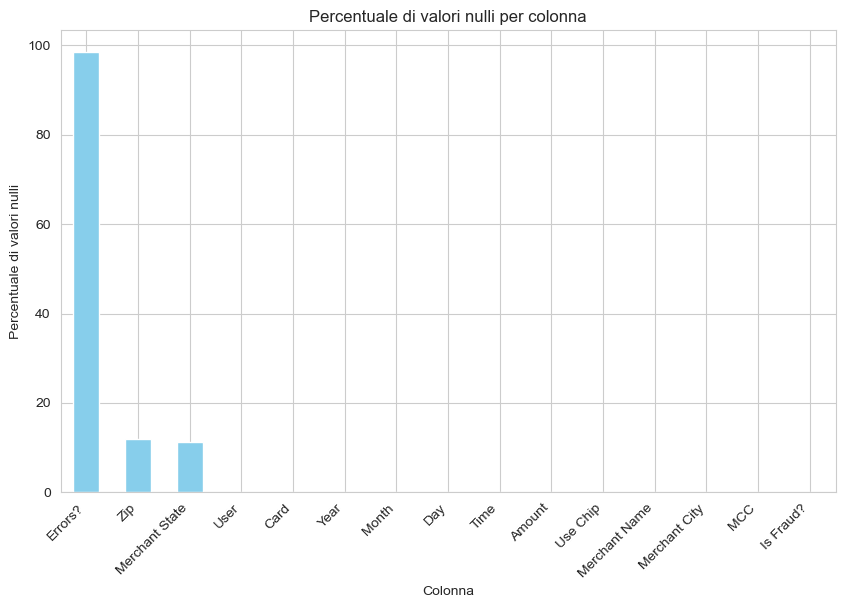

In [39]:
# Calcolo percentuale di valori nulli per ogni colonna
percent_missing = (df.isnull().sum() / len(df)) * 100

# Ordino in ordine decrescente di percentuale
sorted_columns = percent_missing.sort_values(ascending=False)

# Creo un istogramma
plt.figure(figsize=(10, 6))
sorted_columns.plot(kind='bar', color='skyblue')
plt.title('Percentuale di valori nulli per colonna')
plt.xlabel('Colonna')
plt.ylabel('Percentuale di valori nulli')
plt.xticks(rotation=45, ha='right')
plt.show()

La variabile target, dunque quella che il modello dovrà predire, è rappresentata dalla colonna **Is Fraud?**, contenente valori non interi. Dunque, prima di proseguire, per questioni di praticità, vado a creare una nuova colonna chiamata **Fraud**, nella quale mapperò i valori della colonna originale che hanno valore 'Yes' a 1 e quelli che hanno valore 'No' a 0. Infine, rimuovo la colonna originale.

In [40]:
# Creo una nuova colonna 'Fraud' e le assegno i valori di 'Is Fraud?' convertiti in 0 e 1
df['Fraud'] = df['Is Fraud?'].map({'Yes': 1, 'No': 0})

# Elimina la colonna 'Is Fraud?'
df.drop(['Is Fraud?'], axis=1, inplace=True)
df.head(10)

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Fraud
18199893,1470,0,2019,7,10,00:11,$59.18,Chip Transaction,-6853385250336487907,Harwood,MD,20776.0,5813,NaN,0
9731325,822,1,2019,1,14,22:12,$280.91,Online Transaction,4241336128694185533,ONLINE,NaN,NaN,4814,NaN,0
536687,41,3,2010,3,15,07:07,$-144.00,Swipe Transaction,190253443608377572,Hemet,CA,92543.0,3359,NaN,0
13223840,1084,0,2015,9,20,14:58,$6.76,Chip Transaction,-7837310524365334241,Littleton,CO,80122.0,5300,NaN,0
17070521,1384,0,2014,10,12,11:44,$9.17,Swipe Transaction,-5023497618971072366,Gardner,KS,66030.0,5812,NaN,0
792843,55,3,2006,6,10,09:15,$1.36,Swipe Transaction,-6571010470072147219,Rego Park,NY,11374.0,5499,NaN,0
8966297,776,0,2007,2,25,22:31,$97.81,Swipe Transaction,-6974082828836151610,Milwaukee,WI,53224.0,4900,NaN,0
895801,66,0,2007,8,21,13:02,$23.25,Swipe Transaction,3675785629314646441,Gonzales,TX,78629.0,7349,NaN,0
22902727,1880,2,2010,12,31,01:06,$486.70,Swipe Transaction,-3398248499422470718,Atlantic City,NJ,8401.0,7995,NaN,0
5845532,490,5,2015,11,28,13:45,$92.67,Chip Transaction,4722913068560264812,Pompano Beach,FL,33063.0,5411,NaN,0


Continuo a studiare i valori contenuti nelle varie caratteristiche per ottenere una maggiore comprensione dei dati.
**Feature *Errors?*:**

In [41]:
df["Errors?"].unique()

array([nan, 'Bad PIN', 'Insufficient Balance', 'Technical Glitch',
       'Bad Card Number', 'Bad CVV', 'Bad Expiration', 'Bad Zipcode',
       'Insufficient Balance,Technical Glitch', 'Bad Card Number,Bad CVV',
       'Bad CVV,Insufficient Balance',
       'Bad Card Number,Insufficient Balance', 'Bad PIN,Technical Glitch',
       'Bad PIN,Insufficient Balance', 'Bad Card Number,Bad Expiration',
       'Bad Expiration,Bad CVV', 'Bad Expiration,Insufficient Balance'],
      dtype=object)

Questa colonna, a differenza di quanto mi aspettassi dal titolo, non riporta semplicemente se sono avvenuti errori o meno nella transazione, ma ne riporta anche la tipologia di errore.
**Feature *Use Chip*:**

In [42]:
df["Use Chip"].unique()

array(['Chip Transaction', 'Online Transaction', 'Swipe Transaction'],
      dtype=object)

Questa colonna risulta riportare la modalita' con cui è avvenuta una transazione, che può essere:
- Transazione con chip (carta inserita nel lettore del terminale POS)
- Transazione online (acquisto online  &rarr; dati della carta inseriti manualmente in un form)
- Transazione senza chip (carta letta attraverso banda magnetica)  &rarr; meno sicura rispetto al chip, in quanto questo richiede un PIN per validare la transazione

Continuo l'esplorazione dei dati cercando di comprendere eventuali pattern relativi alle frodi.
### Importo delle transazioni
Innanzitutto, ho bisogno di convertire i valori di *Amount* in valori numerici, non prima di aver rimosso il simbolo della valuta che precede le cifre:

In [43]:
# Rimuovo simbolo del dollaro e converto i valori di Amount in float
df["Amount"] = df["Amount"].str.replace("$", "").astype(float)
# Controllo il risultato della modifica
df["Amount"].info()

<class 'pandas.core.series.Series'>
Index: 300000 entries, 18199893 to 18106096
Series name: Amount
Non-Null Count   Dtype  
--------------   -----  
300000 non-null  float64
dtypes: float64(1)
memory usage: 4.6 MB


Prima di estrapolare il dataframe con le sole transazioni fraudolente, siccome non posso convertire Time in un intero, decido di scomporlo in ora e minuto:

In [44]:
# Divido Time in Hour e Minute
df["Hour"] = df["Time"].str[0:2] # Prendo prime due cifre
df["Minute"] = df["Time"].str[3:5] # Prendo ultime due cifre
df.drop(['Time'], axis=1, inplace=True)

C:\Users\Marco\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


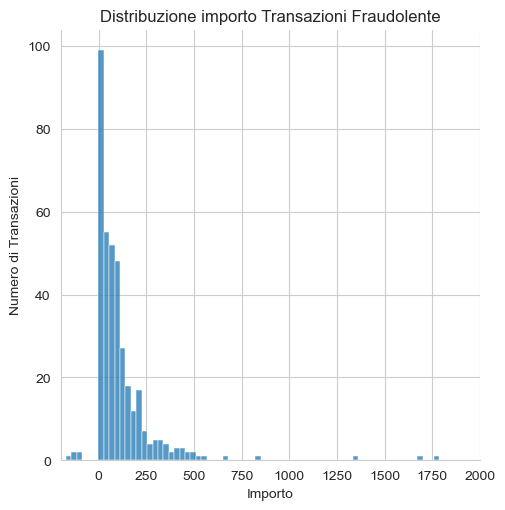

In [45]:
df_fraud = df[df['Fraud'] == 1] # Creo dataset con sole transazioni fraudolente
sns.displot(df_fraud['Amount'].astype(float), kde=False, bins=80)
plt.title('Distribuzione importo Transazioni Fraudolente')
plt.xlabel('Importo')
plt.ylabel('Numero di Transazioni')
plt.xlim(-200, 2000)
plt.show()

Osservo che la maggior parte delle transazioni fraudolente hanno un importo compreso nell'intervallo [0, 250], dunque, generalmente, cifre relativamente basse.

### Distribuzione Geografica
**Nazioni**

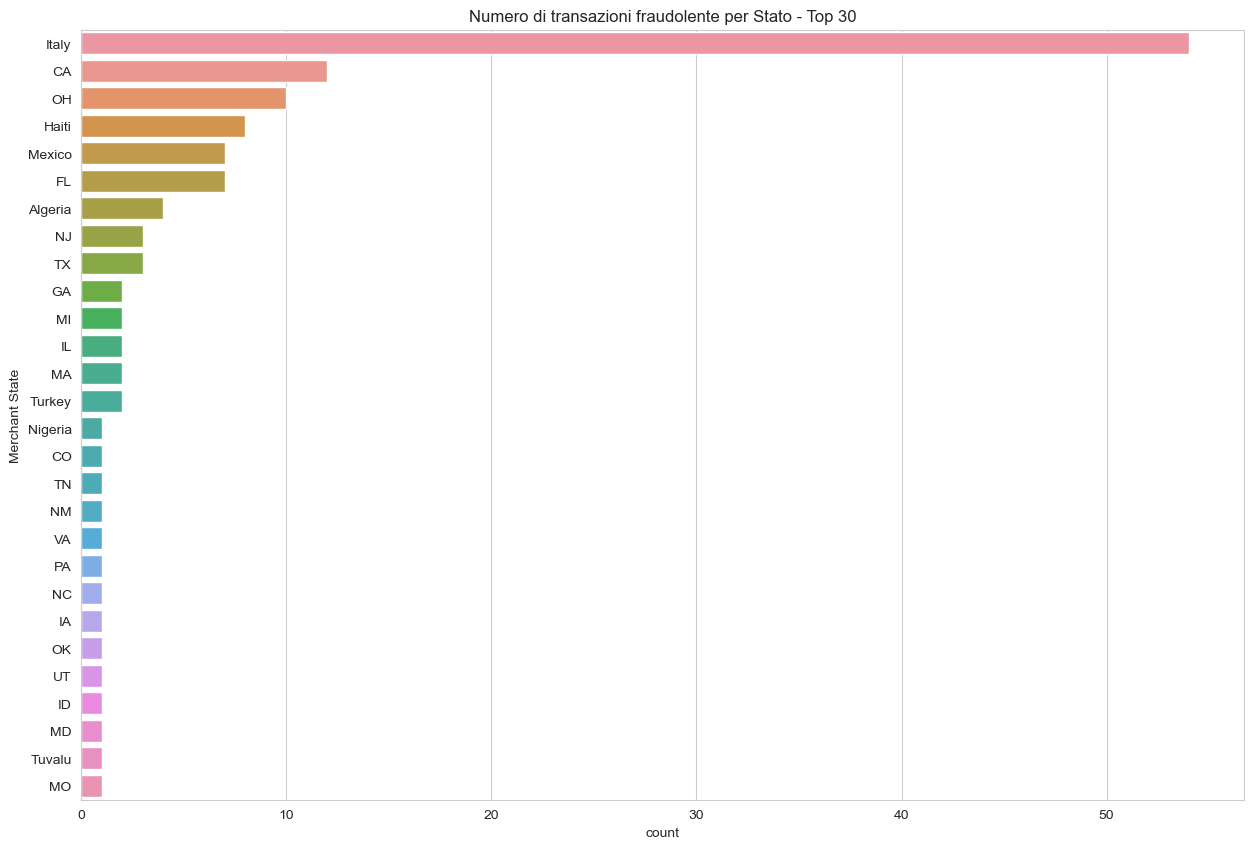

In [46]:
plt.figure(figsize=(15, 10))  
sns.countplot(data=df_fraud, y='Merchant State', order=df_fraud['Merchant State'].value_counts().index)
plt.title('Numero di transazioni fraudolente per Stato - Top 30')
plt.show()

I paesi maggiormente interessati da transazioni fraudolente sono Italia, California, Ohio, Haiti, Messico, Florida, Algeria, New Jersey e Texas. Dunque, negli States è un fenomeno molto comune.
**Città**

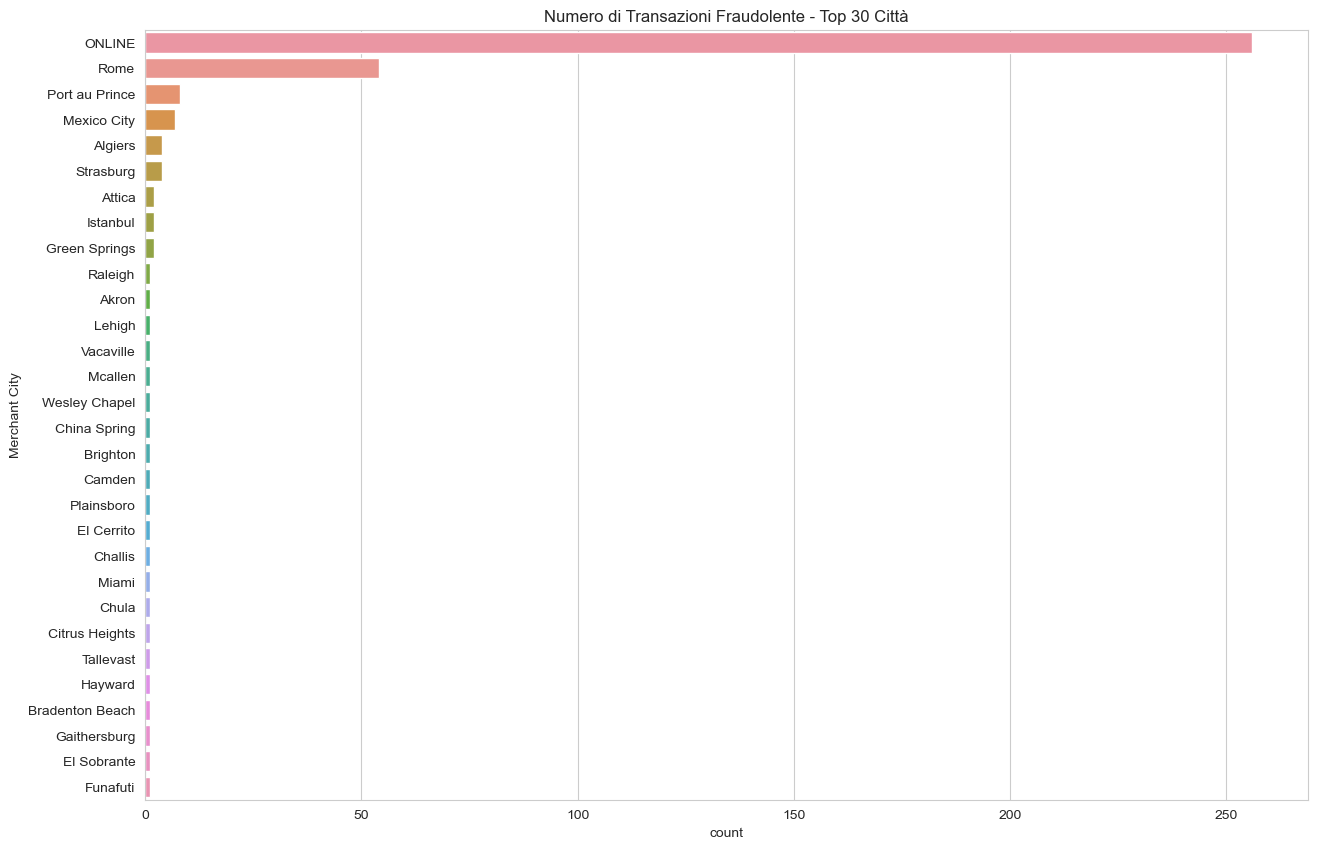

In [47]:
plt.figure(figsize=(15, 10))
top_cities = df_fraud['Merchant City'].value_counts().head(30).index
sns.countplot(data=df_fraud, y='Merchant City', order=top_cities)
plt.title('Numero di Transazioni Fraudolente - Top 30 Città')
plt.show()

Si nota che la maggior parte delle transazioni fraudolente avvengono online.

### Variazione Temporale
**Per Anno**

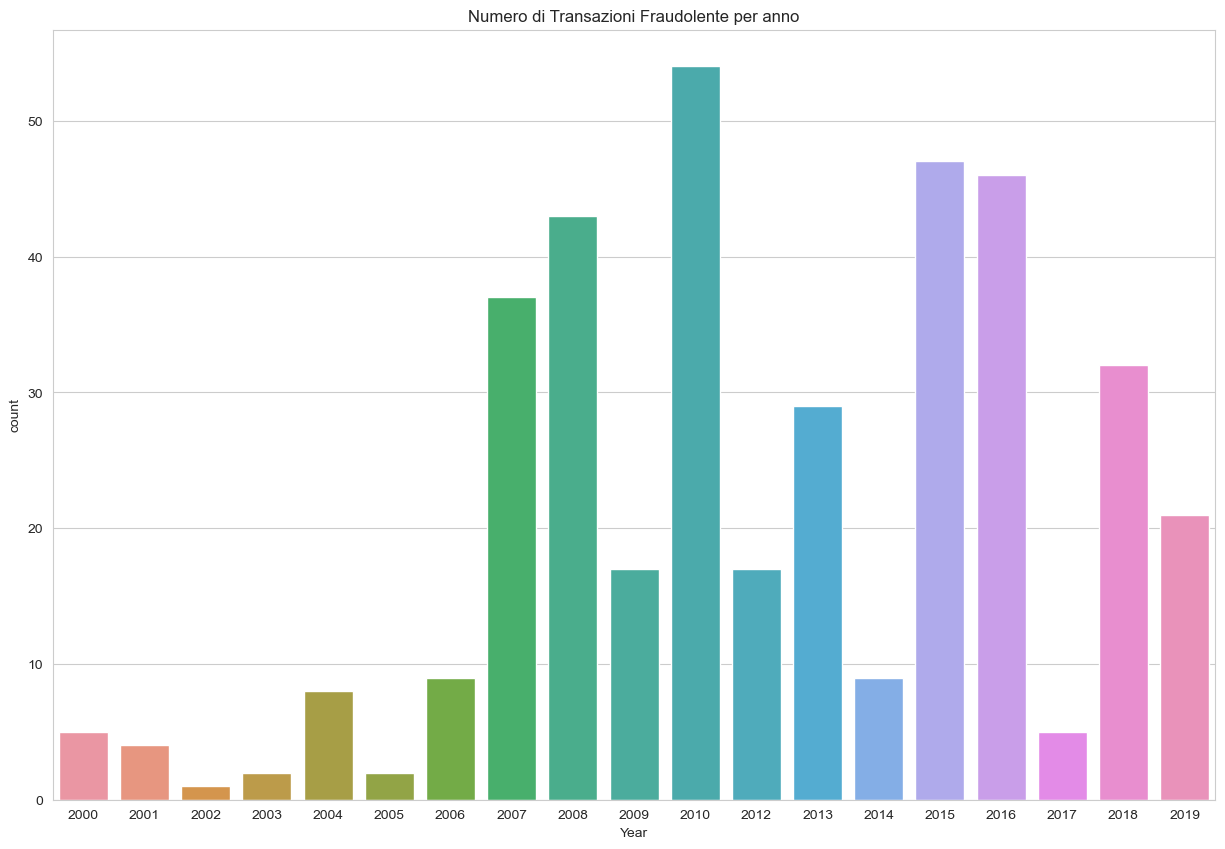

In [48]:
plt.figure(figsize=(15, 10))
sns.countplot(data=df_fraud, x='Year')
plt.title('Numero di Transazioni Fraudolente per anno')
plt.show()

Dal 2006 al 2008, il numero di transazioni fraudolente è andato notevolmente crescendo, raggiungendo, poi, il picco nel 2010.
Il fatto che negli ultimi anni tale valore abbia iniziato a decrescere, puo' indicare un aumento dei controlli e delle misure di sicurezza relative ai pagamenti elettronici.
**Per Mese**

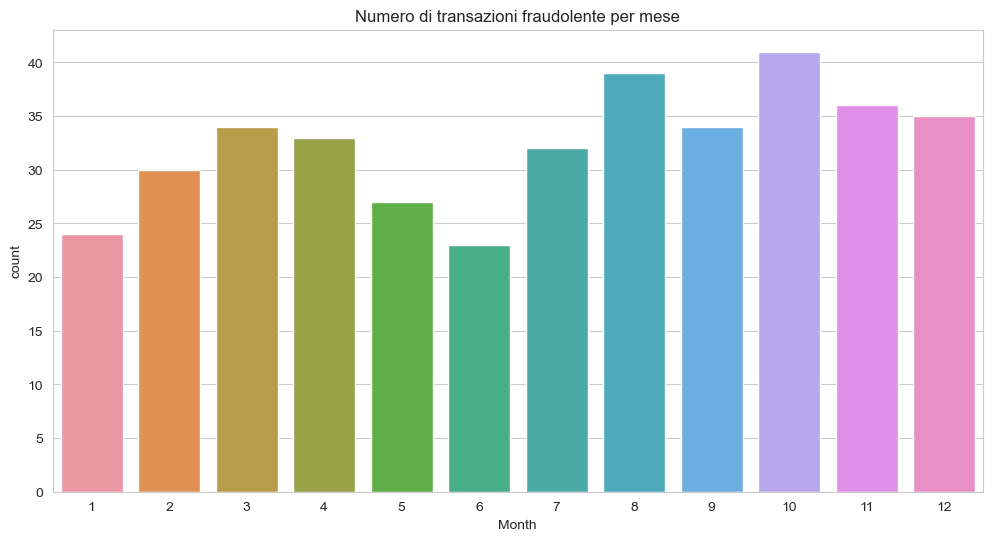

In [49]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_fraud, x='Month')
plt.title('Numero di transazioni fraudolente per mese')
plt.show()

In questo caso, non ci sono particolari variazioni, tuttavia, le frodi aumentano verso la fine dell'anno.
**Per giorno del mese**

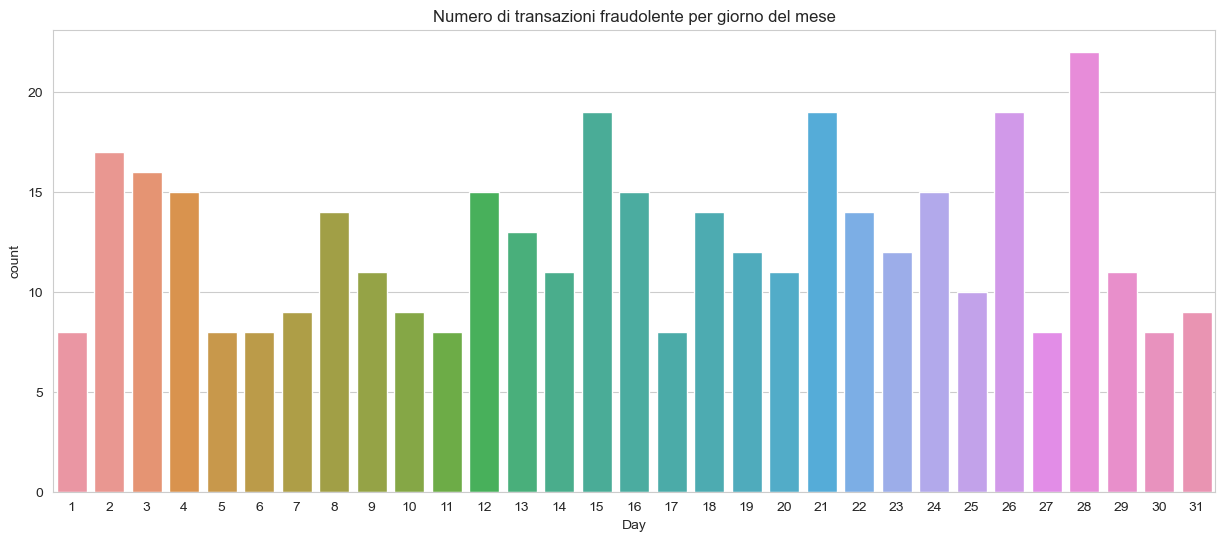

In [50]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df_fraud, x='Day')
plt.title('Numero di transazioni fraudolente per giorno del mese')
plt.show()

Anche qui la distribuzione sembra essere abbastanza uniforme.
**Per ora del giorno**
A questo punto, siccome non posso convertire Time in un intero, decido di scomporlo in ora e minuto:

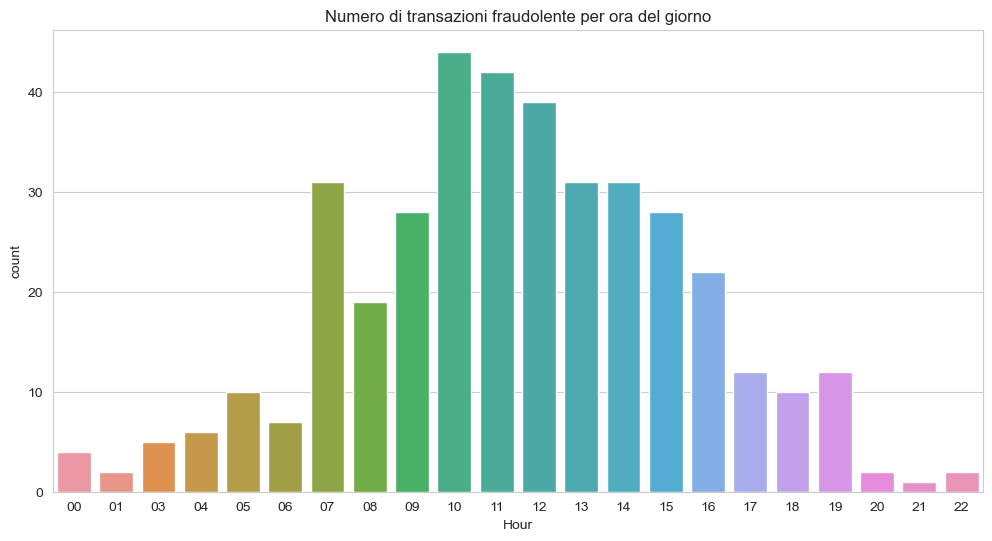

In [51]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_fraud, x='Hour', order=sorted(df_fraud['Hour'].unique()))
plt.title('Numero di transazioni fraudolente per ora del giorno')
plt.show()

I picchi si raggiungono tra le 10 e le 12.
### Modalità di pagamento

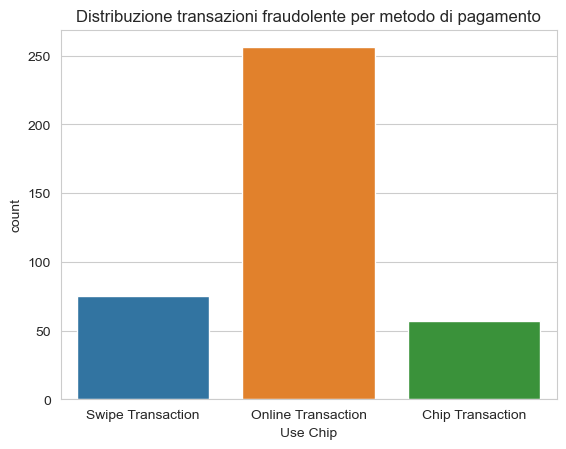

In [52]:
sns.countplot(data=df_fraud, x='Use Chip')
plt.title('Distribuzione transazioni fraudolente per metodo di pagamento')
plt.show()

La maggior parte delle transazioni fraudolente avviene online, come ci si poteva aspettare. Inoltre, le transazioni via chip, che sono, tra tutte, le più sicure, risultano essere, appunto, quelle meno interessate a frodi.

A questo punto passo a verificare se il dataset è sbilanciato, oppure no.


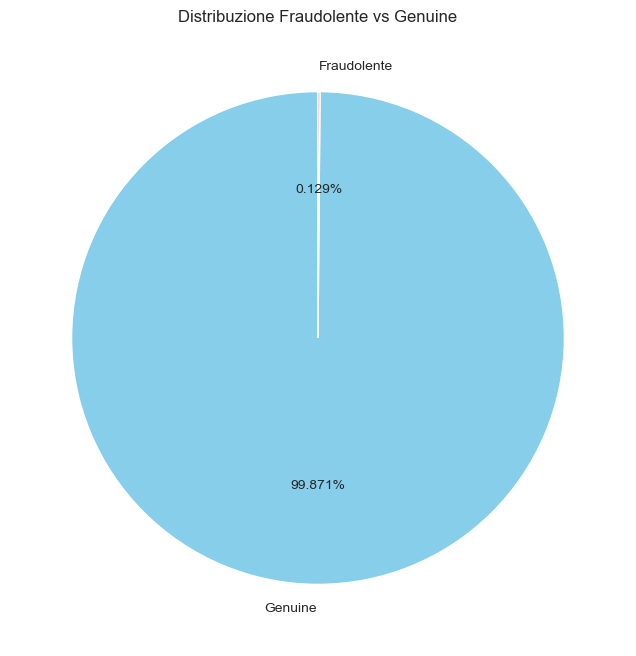

In [53]:
fraud_counts = df['Fraud'].value_counts()

# Crea un grafico a torta
plt.figure(figsize=(8, 8))
plt.pie(fraud_counts, labels=['Genuine', 'Fraudolente'], autopct=lambda p: '{:.3f}%'.format(p), colors=['skyblue', 'salmon'], startangle=90)
plt.title('Distribuzione Fraudolente vs Genuine')
plt.show()

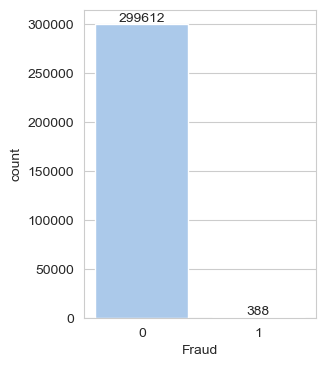

In [54]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='Fraud',data=df,palette="pastel")
for i in ax.containers:
    ax.bar_label(i,)

Come mostrano i grafici appena riportati, il dataset si mostra estremamente sbilanciato, con solo lo 0,129% delle transazioni che risultano essere fraudolente: 388 casi di frode contro le 299612 transazioni autorizzate.

## Data Preparation
---
### Data Cleaning
A questo punto, sulla base delle osservazioni fatte in fase di Data Understanding, procedo con la pulizia del dataset.

Come osservato sopra, studiando l'output del metodo unique() applicato sulla colonna *Errors?*, questa tabella riporta le varie tipologie di errore verificatesi nelle varie transazioni. Se non si verifca alcun errore, il valore risulta essere nullo. Dunque posso procedere alla sostituzione dei valori nulli con un valore che indica che non si sono verificati errori (imputazione deduttiva). Inoltre, per questioni di leggibilità, vado a rinominare la colonna in *Errors*.

In [55]:
# Imputazione deduttiva dei valori nulli
df['Errors?']= df['Errors?'].fillna("No error")
df['Errors'] = df['Errors?']
df.drop(['Errors?'], axis=1, inplace=True)

# Riporto la variabile target come ultima colonna
target_v = df['Fraud']
df.drop(['Fraud'], axis=1, inplace=True)
df['Fraud'] = target_v
# df.head(10)

In [56]:
# Controllo l'esito dell'operazione
error_null_values = df["Errors"].isnull().sum()
print('Nuovo numero di valori nulli: ', error_null_values)

Nuovo numero di valori nulli:  0


A questo punto vado a rimuovere le colonne *Merchant State* e *Zip* in quanto contengono valori nulli e, ad ogni modo, possono essere ricavate dalla caratteristica *Merchant City*.

In [57]:
df.drop(['Merchant State', 'Zip'], axis=1, inplace=True)

Infine, siccome il modello avrà bisogno di dati numerici, vado a convertire i valori delle features *Merchant City*, *Use Chip*, *Errors* in valori numerici, utilizzando il metodo *LabelEncoder()*, della libreria scikit-learn, che, appunto, converte variabili categoriche in formato numerico, assegnando ad ognuna un intero univoco in ordine di scoperta.

In [58]:
from sklearn.preprocessing import LabelEncoder

In [59]:
df["Merchant City"]=LabelEncoder().fit_transform(df["Merchant City"])
df["Use Chip"]=LabelEncoder().fit_transform(df["Use Chip"])
df["Errors"]=LabelEncoder().fit_transform(df["Errors"])
df.head(10) 

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,MCC,Hour,Minute,Errors,Fraud
18199893,1470,0,2019,7,10,59.18,0,-6853385250336487907,2610,5813,00,11,15,0
9731325,822,1,2019,1,14,280.91,1,4241336128694185533,4502,4814,22,12,15,0
536687,41,3,2010,3,15,-144.00,2,190253443608377572,2671,3359,07,07,15,0
13223840,1084,0,2015,9,20,6.76,0,-7837310524365334241,3493,5300,14,58,15,0
17070521,1384,0,2014,10,12,9.17,2,-5023497618971072366,2253,5812,11,44,15,0
792843,55,3,2006,6,10,1.36,2,-6571010470072147219,5220,5499,09,15,15,0
8966297,776,0,2007,2,25,97.81,2,-6974082828836151610,3976,4900,22,31,15,0
895801,66,0,2007,8,21,23.25,2,3675785629314646441,2370,7349,13,02,15,0
22902727,1880,2,2010,12,31,486.70,2,-3398248499422470718,244,7995,01,06,15,0
5845532,490,5,2015,11,28,92.67,0,4722913068560264812,5001,5411,13,45,15,0


### Feature Scaling
Vado ora ad osservare le distribuzioni dei valori delle varie caratteristiche e le confronto tra loro.

In [61]:
df.describe()

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,MCC,Errors,Fraud
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,3.000000e+05,300000.000000,300000.000000,300000.000000,300000.000000
mean,999.646807,1.351237,2011.959617,6.523280,15.711017,43.595661,1.375403,-4.918042e+17,3541.174517,5561.354607,14.949873,0.001293
std,570.107840,1.404363,5.095499,3.476527,8.787560,82.174141,0.864460,4.757684e+18,1912.532388,880.968106,0.592285,0.035940
min,0.000000,0.000000,1991.000000,1.000000,1.000000,-500.000000,0.000000,-9.219257e+18,0.000000,1711.000000,0.000000,0.000000
25%,509.000000,0.000000,2008.000000,3.000000,8.000000,9.310000,0.000000,-4.500543e+18,1932.000000,5300.000000,15.000000,0.000000
50%,1005.000000,1.000000,2013.000000,7.000000,16.000000,30.090000,2.000000,-7.948098e+17,3920.000000,5499.000000,15.000000,0.000000
75%,1477.000000,2.000000,2016.000000,10.000000,23.000000,65.000000,2.000000,3.168767e+18,4869.000000,5812.000000,15.000000,0.000000
max,1999.000000,8.000000,2020.000000,12.000000,31.000000,3205.940000,2.000000,9.222877e+18,6973.000000,9402.000000,16.000000,1.000000


Osservo che ci sono più valori molto diversi tra loro, dunque decido di normalizzare tutti i valori nell'intervallo [0, 1] utilizzando uno dei metodi di normalizzazione più comuni: **Min-max normalization**.

In [62]:
from sklearn.preprocessing import MinMaxScaler

In [63]:
# Seleziono tutte le colonne tranne Fraud
norm_features = df.columns.difference(['Fraud'])

# Inizializzo scaler
scaler = MinMaxScaler()

# Eseguo min-max normalization
df[norm_features] = scaler.fit_transform(df[norm_features])

# Controllo il risultato
df.head(10)

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,MCC,Hour,Minute,Errors,Fraud
18199893,0.735368,0.000,0.965517,0.545455,0.300000,0.150887,0.0,0.128286,0.374301,0.533351,0.000000,0.186441,0.9375,0
9731325,0.411206,0.125,0.965517,0.000000,0.433333,0.210718,0.5,0.729883,0.645633,0.403459,0.956522,0.203390,0.9375,0
536687,0.020510,0.375,0.655172,0.181818,0.466667,0.096062,1.0,0.510218,0.383049,0.214276,0.304348,0.118644,0.9375,0
13223840,0.542271,0.000,0.827586,0.727273,0.633333,0.136743,0.0,0.074934,0.500932,0.466649,0.608696,0.983051,0.9375,0
17070521,0.692346,0.000,0.793103,0.818182,0.366667,0.137393,1.0,0.227509,0.323103,0.533221,0.478261,0.745763,0.9375,0
792843,0.027514,0.375,0.517241,0.454545,0.300000,0.135286,1.0,0.143598,0.748602,0.492524,0.391304,0.254237,0.9375,0
8966297,0.388194,0.000,0.551724,0.090909,0.800000,0.161311,1.0,0.121742,0.570199,0.414640,0.956522,0.525424,0.9375,0
895801,0.033017,0.000,0.551724,0.636364,0.666667,0.141192,1.0,0.699216,0.339882,0.733065,0.565217,0.033898,0.9375,0
22902727,0.940470,0.250,0.655172,1.000000,1.000000,0.266248,1.0,0.315636,0.034992,0.817059,0.043478,0.101695,0.9375,0
5845532,0.245123,0.625,0.827586,0.909091,0.900000,0.159924,0.0,0.755995,0.717195,0.481082,0.565217,0.762712,0.9375,0
